# Identifying the entrance locations for selected POIs

<hr>

### Why we need to identify the entrance locations for some POIs ?

- 100m Walking Radius (R) given for a DOP may not capture POIs with large land areas. Increasing the  R as a remedy tends to capture unnecessary POIs. 
- More suitable solution is to identify the possible entering points or passenger DOPs for these POIs  
- Developed solution is two-fold. <br/>
    1.)  Identifying the possible POIs with large land areas from total POI dataset. (Pre-requsite) <br/>
    2.)  Identifying the possible entering points for the selected POIs  

The following image shows the Complete process


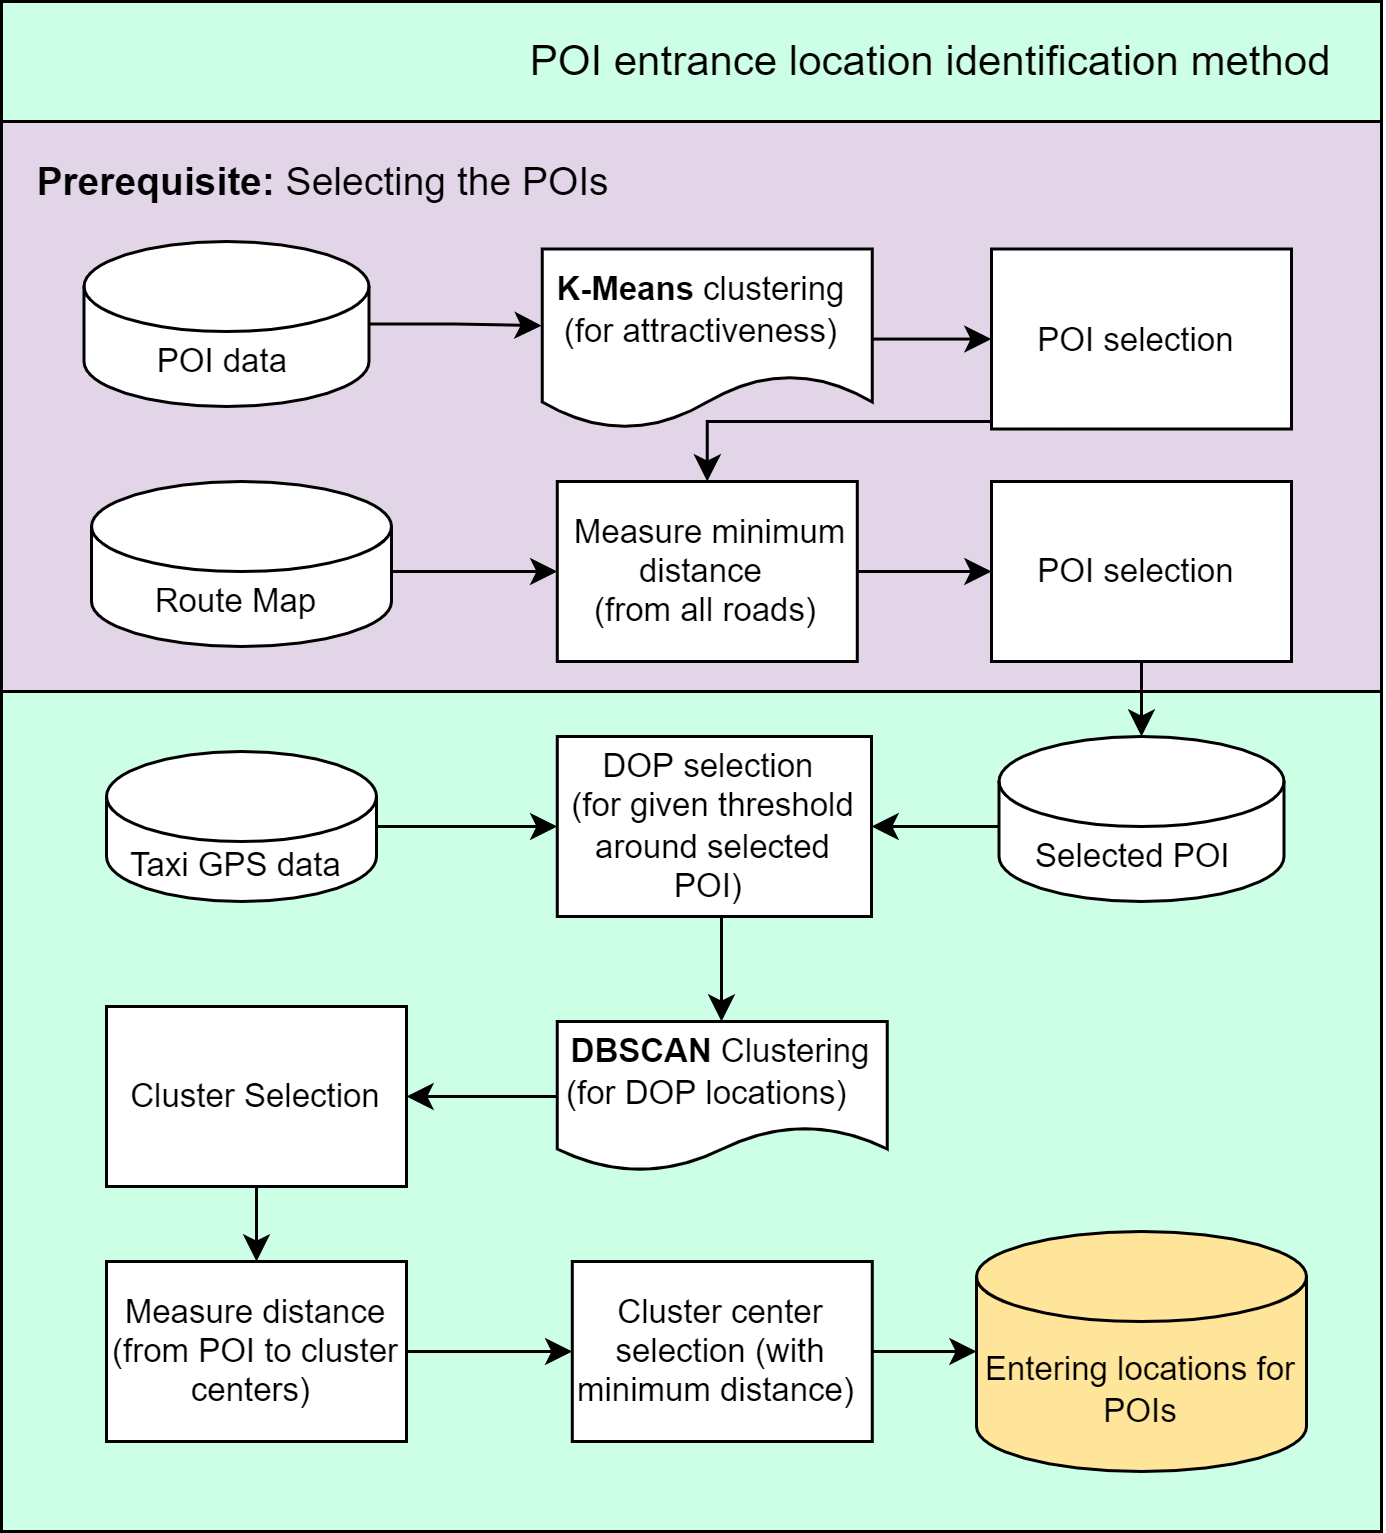

In [7]:
Image("poi_selection_graph.png", width=400, height=700)

## Package Import 

In [8]:
import pandas as pd 
import math
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import seaborn as sns
import folium
from math import cos, sqrt 
pd.options.mode.chained_assignment = None
from IPython.display import Image

In [9]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

## Importing data 

### POI/places data

In [24]:
# import the original/raw POI data

places = pd.read_csv('Original_POI_data.csv',index_col = 0)
places.reset_index(inplace = True, drop = True)

### Taxi data

In [31]:
# import the taxi data and convert it to a geodataframe 
taxidata = pd.read_csv('Taxi_trip_data.csv', index_col = 0, parse_dates = [13])
geometry = [Point(xy) for xy in zip(taxidata.dropoff_long, taxidata.dropoff_lat)]
taxidata  = gpd.GeoDataFrame(taxidata, crs="EPSG:4326", geometry=geometry)
taxidata.crs = "EPSG:4326"

### Road network data 

In [100]:
# import filter the road network for the selected area 

# import road network data/ shape file 
slroads = gpd.read_file('road network\\hotosm_lka_roads_lines.shp',crs = {'init': 'epsg:4326'})

# import land area shape file 
sri_lanka = gpd.read_file('land area\\lka_admbnda_adm2_slsd_20200305.shp',crs = {'init': 'epsg:4326'})

# filter for the required land area 
colombo = sri_lanka[sri_lanka['ADM2_EN']=='Colombo']
colombo.reset_index(drop=True, inplace=True)
mask = slroads.within(colombo.loc[0,'geometry'])
colombo_roads = slroads.loc[mask]

## PreRequisite - Selecting the POIs

It is assumed that a POI should have a higher attraction level and considerable distance from the nearest road to get selected.  This causes to select only impactful POIs that is neglected through the allowed maximum Walking Radius (R) around the DOP of a trip. The two assumptions are assessed by using the <b> ‘number of reviews’ </b> attribute provided with the poi data and measured <b> ‘linear distance from the nearest road’ </b> respectively. Use of <b> k-means </b> clustering to these two features and selecting the clusters with higher number of reviews and higher distances assist in selecting the required POIs. The advantage of using a clustering method for this purpose comes with its capability to group similar data and providing the ability to select the required groups. 


Providing a Radius (R) for a POI assist to select the taxi trips that had attracted to the surrounding of it using the taxi DOPs. Then, Density-Based Spatial Clustering of Applications with Noise  <b> (DBSCAN) </b> algorithm can be used with its optimized parameters for the DOPs to capture the clustered trip attraction points around that POI. Two parameters as maximum distance between two DOPs and minimum number of DOPS that need to select the clusters are required to optimize the algorithm. This assist to select the possible entering locations by taking the center of the cluster with the minimum distance from the POI. 

### Cluster and Filter for Attractiveness

KNN clustering is used for the 'no of ratinngs' attribute of Places dataset to identify what kind of groups are within the attribute, which may help to remove the groups or clusters of places that are not much attractive.

To do that, it is required to turn the Null values to 0 in the 'no of ratings' attibute

In [34]:
for idx,row in places.iterrows():
    if math.isnan(row['no_of_ratings']) == True:
            places.loc[idx,'no_of_ratings'] = 0

In [35]:
Xy = pd.DataFrame(places[['no_of_ratings']])

In [36]:
scaler = StandardScaler()

In [37]:
X = scaler.fit_transform(Xy)

In [38]:
inertialist = []
nclusters = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
for i in nclusters:
    model = KMeans(n_clusters=i)
    model.fit(X)
    inert = model.inertia_
    inertialist.append(inert)

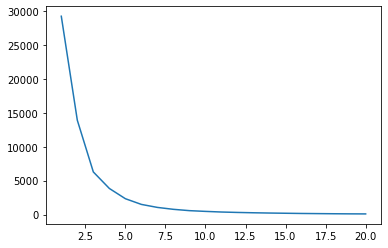

In [39]:
plt.plot(nclusters , inertialist)

it is decided to go with 15 clusters 

checking what would be the optimal number of clusters is done. However, the optimal is mainly selected referrring the minimum, maximum value of ratings from the obtained from the clusters. In that case it was decided to selected 14 clusters and remove 

In [40]:
model = KMeans(n_clusters=15, random_state=32)

In [41]:
model.fit(X)

KMeans(n_clusters=15, random_state=32)

In [42]:
clusterlabels = model.predict(X)

In [43]:
Xy['cluster_name'] = clusterlabels.tolist()

In [44]:
Xy.groupby('cluster_name')['no_of_ratings'].max()

cluster_name
0        84.0
1     11428.0
2      1373.0
3     18746.0
4      3612.0
5       621.0
6      2770.0
7      7493.0
8        22.0
9       374.0
10      937.0
11     1959.0
12      198.0
13     9011.0
14     4691.0
Name: no_of_ratings, dtype: float64

In [45]:
(unique, counts) = np.unique(clusterlabels, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

[[    0  2124]
 [    1     3]
 [    2    68]
 [    3     1]
 [    4    18]
 [    5   164]
 [    6    23]
 [    7     3]
 [    8 25689]
 [    9   277]
 [   10   115]
 [   11    41]
 [   12   684]
 [   13     2]
 [   14     7]]


since the cluster 0 has a maximum number of 36 ratings, it was decided to remove that cluster, the following helps to identify the number of places belongs to each cluster. it can be seen that majority of the places belong to the removed cluster 

then we remove the unwanted cluster and take the data (with the indexes) to go for the second clustering, which is based on the distance from the road  

In [46]:
Xy =  Xy[Xy['cluster_name'] != 8]

### Cluster and Filter for distance

before do this, we have to measure the linear distance a places from the selected places data has from the roads. and that is done in the following first 

In [48]:
places = places.loc[Xy.index]

In [49]:
# measure the distance from the selected road network
for idx,row in places.iterrows():
    Point_DOP = Point(row['lng'],row['lat'])
    Buffer = Point_DOP.buffer(100*0.001/110) 
    
    idxlists = []
    for idxx,roww in colombo_roads.iterrows():   
       if Buffer.intersects(roww['geometry']) == True:
            idxlists.append(idxx)      
    places.loc[idx,'no_of_roads'] = len(idxlists)
    
    if len(idxlists) > 0:
        
        selectedroadss = colombo_roads.loc[idxlists,:]
        
        distancelist = []
        for idxxx,rowss in selectedroadss.iterrows():
            distance = (Point_DOP.distance(rowss['geometry']))*10000
            distancelist.append(distance)
        places.loc[idx,'road_min_distace'] = min(distancelist)

In [52]:
places.head()

,name,place_id,lat,lng,types,vicinity,no_of_ratings,avg_rating,geometry,type_1,dual_1,dual_2,no_of_roads,road_min_distace
0,Khairiya Muslim Girl's Grand College,ChIJS6PgLw9Z4joRADXcRN0MYh0,6.929464,79.868975,"['school', 'point_of_interest', 'establishment']","219 Sri Vajiragnana Mawatha, Colombo",27.0,4.4,POINT (79.8689747 6.929464200000002),school,NaN,NaN,1.0,0.829677
36,Makutarama Myanmar Temple,ChIJVxc36ghZ4joRVrufIFGSRhA,6.929036,79.870371,"['place_of_worship', 'point_of_interest', 'est...","Reservoir Road, Colombo",66.0,4.2,POINT (79.87037119999999 6.9290365),place_of_worship,NaN,NaN,4.0,5.258524
37,Clifton Balika Maha Vidyalaya,ChIJMSvg0A5Z4joR6Y2kwXHSD4w,6.926980,79.868559,"['school', 'point_of_interest', 'establishment']",Colombo,32.0,3.8,POINT (79.86855919999999 6.9269799),school,NaN,NaN,3.0,1.050879
45,Ananda Balika Vidyalaya,ChIJ89pvRwlZ4joR-8vJh0v2hB8,6.926378,79.869846,"['school', 'point_of_interest', 'establishment']","01000 Maligakanda Road, Colombo",82.0,4.3,POINT (79.8698462 6.9263778),school,NaN,NaN,6.0,5.078381
52,Mahabodhi Viharaya,ChIJ-RmXNglZ4joRJURgbkCDwyM,6.926740,79.868784,"['place_of_worship', 'point_of_interest', 'est...","Maligakanda Road, Colombo",71.0,4.6,POINT (79.8687838 6.926740199999998),place_of_worship,NaN,NaN,4.0,1.842632


In [61]:
for idx,row in places.iterrows():
    if math.isnan(row['road_min_distace']) == True:
            places.loc[idx,'road_min_distace'] = 0

In [62]:
Xy = pd.DataFrame(places[['road_min_distace']])

In [63]:
scaler = StandardScaler()

In [64]:
X = scaler.fit_transform(Xy)

checking what would be the optimal number of clusters is done. However, the optimal is mainly selected referrring the maximum values for the distance from the obtained from the clusters. In that case it was decided to selected 14 clusters and remove 

In [65]:
inertialist = []
nclusters = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
for i in nclusters:
    model = KMeans(n_clusters=i)
    model.fit(X)
    inert = model.inertia_
    inertialist.append(inert)

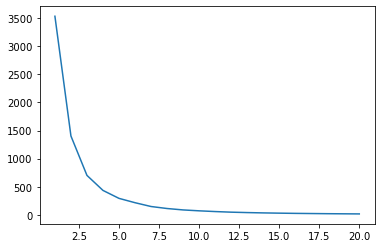

In [66]:
plt.plot(nclusters , inertialist)

It is decided to go with 15 clusters 

In [67]:
model = KMeans(n_clusters=15, random_state=32)

In [68]:
model.fit(X)

KMeans(n_clusters=15, random_state=32)

In [69]:
clusterlabels = model.predict(X)

In [70]:
Xy['cluster_name'] = clusterlabels.tolist()

In [71]:
Xy.groupby('cluster_name')['road_min_distace'].max()

cluster_name
0     1.674899
1     4.814240
2     0.611971
3     3.406968
4     1.116543
5     8.518076
6     2.837493
7     4.097493
8     2.364207
9     6.710782
10    0.318823
11    0.866451
12    1.385197
13    5.521592
14    1.990449
Name: road_min_distace, dtype: float64

In [72]:
(unique, counts) = np.unique(clusterlabels, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

[[  0 398]
 [  1  45]
 [  2 343]
 [  3 102]
 [  4 535]
 [  5  14]
 [  6 159]
 [  7  78]
 [  8 236]
 [  9  20]
 [ 10 278]
 [ 11 507]
 [ 12 493]
 [ 13  39]
 [ 14 283]]


Since the cluster x has reletively lower distance, we remove that cluster and take the rest of the clusters for our analysis. These finally filtered data are the most suitable POIs to identify entering locations in improving the Trip purpose inference results. 

In [75]:
Xy =  Xy[Xy['cluster_name'] != 10]
Xy =  Xy[Xy['cluster_name'] != 11]
Xy =  Xy[Xy['cluster_name'] != 2]
Xy =  Xy[Xy['cluster_name'] != 4]

In [76]:
Xy

,road_min_distace,cluster_name
36,5.258524,13
45,5.078381,13
52,1.842632,14
55,1.804010,14
95,1.508724,0
...,...,...
29131,1.488900,0
29149,1.333438,12
29150,1.333438,12
29160,1.261168,12


In [94]:
Xy.index

Int64Index([   36,    45,    52,    55,    95,   100,   104,   108,   150,
              165,
            ...
            29039, 29057, 29092, 29110, 29126, 29131, 29149, 29150, 29160,
            29185],
           dtype='int64', length=1867)

In [ ]:
places = places.loc[Xy.index]

## Entering Location identification

DBSCAN algorithm is used to identify the clusters of drop off points, which helps to do it by two parameters as eps and minimum number of gps points. 

Estimating the eps value that could be used in clustering the taxi drop off points is done. Here it is done only for a sample Place. When trying out different samples, it was obvisous that the 0.0002 is the most viable value that can be used.  

### Eps value estimation 

In [80]:
place_index = 'ChIJS6PgLw9Z4joRADXcRN0MYh0'

In [85]:
places.set_index('place_id', inplace = True)

In [87]:
# Selecting a sample point to check the eps value 
POI = places.loc[place_index,['lat','lng']].values 
Point_POI = Point(POI[1],POI[0]) # convert to point type
Buffer = Point_POI.buffer(200) # create the buffer for the Point giving the radius 
mask = taxidata.within(Buffer) ## filter the data for the required buffer zone 
radius_data = taxidata.loc[mask]

X = radius_data[['dropoff_lat','dropoff_long']]

In [88]:
neigh = NearestNeighbors(n_neighbors = 2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

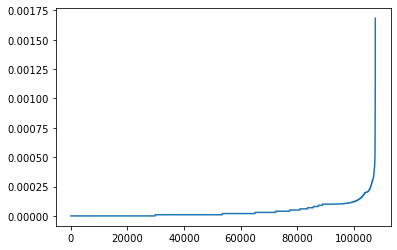

In [89]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

The y values at the arm bend of the above curve can be identified as the best value the eps. because it shows the number of taxi drop off points that got into the clusters 

### Assigning the entering location

After determining the eps value, we can go to our main task, which is identifying the entering locations for attractive big land area places. Here we cluster the taxi trip dops around a radius of 200m of radius (except for few places which has a higher distance from the road (cluster no 1) ).  Definitely more clusters can be found for a one place. In that case the cluster with the minimum distance from the considered place is selected. 

Another fact is that although we cannot take a exact center location for the cluster after observations it was decided that a viable center point can be obtained just by taking the minimum of both lat and long values. In that case that value is used in this analysis. This value also given as the possible entering location. 

There are possibilities that some places might have one or more entering locations. For an instance, hospitals. In that  case, the distance to all of these clusters are measured and if the distance gap is not substantial(here we assumed it as 20m) it was decided to keep them all as entering locations. 


In [90]:
## smalll fun to calculate the starightline distance, source: STACKOVERFLOW
def qick_distance(Lat1, Long1, Lat2, Long2):
    """smalll fun to calculate the starightlits distance""" 
    
    x = Lat2 - Lat1
    y = (Long2 - Long1) * cos((Lat2 + Lat1)*0.00872664626)  
    return 111.319 * sqrt(x*x + y*y)*1000

In [ ]:
for idx,row in places.iterrows():
   
    place_index = idx ## input the index of the POI 
    
    if row['cluster_labels'] == 1:
        radius = 400*0.001/110
    else:
        radius = 200*0.001/110 #(110m = 0.001) (##idk about this convertion but it is right)

    POI = places.loc[place_index,['lat','lng']].values 

    Point_POI = Point(POI[1],POI[0]) # convert to point type

    Buffer = Point_POI.buffer(radius) # create the buffer for the Point giving the radius 

    mask = taxidata.within(Buffer) ## filter the data for the required buffer zone 
    radius_data = taxidata.loc[mask]

    X = radius_data[['dropoff_lat','dropoff_long']]
    
    if X.shape[0] == 0:
        
        continue
    
    model = DBSCAN(eps=0.0002, min_samples = 10)
    
    model.fit(X)
    
    clusterlabels = model.labels_
    
    radius_data['cluster_no'] = clusterlabels.tolist()
    
    clusters = np.sort(radius_data['cluster_no'].unique())
    
    grouped_clusters = radius_data.groupby('cluster_no')
    
    clusters_for_POI = pd.DataFrame()
    
    for i, cluster in enumerate(clusters):
        selected_cluster = grouped_clusters.get_group(cluster)
        mean_lat, mean_lng  =  selected_cluster['dropoff_lat'].mean() , selected_cluster['dropoff_long'].mean()
        clusters_for_POI.loc[i,'cluster'] = cluster
        clusters_for_POI.loc[i,'lat'] = mean_lat
        clusters_for_POI.loc[i,'lng'] = mean_lng
        clusters_for_POI.loc[i,'distance'] = qick_distance(POI[0], POI[1], mean_lat, mean_lng)
    clusters_for_POI =  clusters_for_POI.drop(0)
    
    if clusters_for_POI.shape[0] != 0: ## process if only there are good clusters. 
        
        clusters_for_POI['distance_difference'] = clusters_for_POI['distance'] - clusters_for_POI['distance'].min()

        for idxx,rows in clusters_for_POI.iterrows(): # drop all the clusters that has a distance more than 20m and keep the rest 
            if rows['distance_difference'] > 20:
                clusters_for_POI.drop(idxx, inplace = True)
        
        for idxxx,rowss in clusters_for_POI.iterrows() : # save the cluster locations as new places in the places dataset 
            new_index = place_index +str(idxxx)
            places.loc[new_index,:] = places.loc[place_index,:]
            places.loc[new_index,['lat_1','lng_1']] = rowss['lat'], rowss['lng']

In [ ]:
places.to_csv('Entrance_identified_POIs.csv')

## EDA

### Visualizing clustered DOPs around a POI

In [ ]:
place_index = 'ChIJY-4CjWNZ4joRGZP7dE2cZZ8' ## input the index of the trip DOP want to consider 
radius = 200*0.001/110 #(110m = 0.001) 

In [ ]:
POI = places.loc[place_index,['lat','lng']].values 
Point_POI = Point(POI[1],POI[0]) # convert to point type
Buffer = Point_POI.buffer(radius) # create the buffer for the Point giving the radius 
mask = taxidata.within(Buffer) ## filter the data for the required buffer zone 
radius_data = taxidata.loc[mask]

In [25]:
grouped_clusters = radius_data.groupby('cluster_no')

In [ ]:
## mapping 
m = folium.Map(location=POI,zoom_start=25)
folium.Marker(list(POI), icon=folium.Icon(color='red',icon='none')).add_to(m)
for idx, row in radius_data.iterrows():
    folium.Marker([row['dropoff_lat'], row['dropoff_long']]).add_to(m)
## , popup=row['name']+str("\n")+row['type_1']+str("\n")+str(row['no_of_ratings']
folium.GeoJson(Buffer).add_to(m)

In [ ]:
## mapping 
m = folium.Map(location=POI,zoom_start=25)
folium.Marker(list(POI), icon=folium.Icon(color='red',icon='none')).add_to(m)
clusters = np.sort(radius_data['cluster_no'].unique())
grouped_clusters = radius_data.groupby('cluster_no')
colors = ['black','orange','yellow', 'beige', 'darkblue', 'darkgreen', 'cadetblue','lightgreen', 'gray']
for i, cluster in enumerate(clusters):
    selected_cluster = grouped_clusters.get_group(cluster)
    mean_lat, mean_lng  =  selected_cluster['dropoff_lat'].mean() , selected_cluster['dropoff_long'].mean()
    folium.Marker([mean_lat, mean_lng],  icon=folium.Icon(color=colors[i+1],icon='none')).add_to(m)
    for idx, row in  selected_cluster.iterrows():
        folium.Marker([row['dropoff_lat'], row['dropoff_long']],  icon=folium.Icon(color=colors[i],icon='none')).add_to(m)
## , popup=row['name']+str("\n")+row['type_1']+str("\n")+str(row['no_of_ratings']
folium.GeoJson(Buffer).add_to(m)